<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/master/notebooks/run_cellpose_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose with/without training

(thanks to Matteo Carandini for setting this up)

UPDATED DEC 2020 for TORCH VERSION cellpose v0.6

UPDATED NOV 2021 for cellpose / omnipose v0.7

## installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

Note that cellpose uses the latest version of numpy, so please click the "Restart runtime" button once the install completes.

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 6.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Check CUDA version and GPU

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
Tue Sep 26 17:38:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P5    38W / 350W |  11760MiB / 24576MiB |     35%      Default |
|                               |                      |                  N/A |
+---

import libraries and check GPU (the first time you import cellpose the models will download).

In [2]:
import numpy as np
import time, os, sys
import tifffile
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();


>>> GPU activated? 1
2023-09-26 17:38:26,343 [INFO] WRITING LOG OUTPUT TO /home/xzhang/.cellpose/run.log
2023-09-26 17:38:26,343 [INFO] 
cellpose version: 	2.2.3 
platform:       	linux 
python version: 	3.8.16 
torch version:  	2.0.1+cu117


Download sample images

# load 3d dataset colon dataset

In [3]:
from natsort import natsorted
import glob
import os 

data_folder = "/data/download_data/colon_dataset/colon_30/"
image_files = natsorted(glob.glob(data_folder + 'images/*.tif'))
seg_files = natsorted(glob.glob(data_folder + 'labels/*.tif'))
fold = 1
valid_img_files = [f for i,f in enumerate(image_files) if i%5 == fold-1]
valid_seg_files = [f for i,f in enumerate(seg_files) if i%5 == fold-1]

test_img_files = [f for i,f in enumerate(image_files) if i%5 == fold]
test_seg_files = [f for i,f in enumerate(seg_files) if i%5 == fold]

train_img_files = [f for f in image_files if f not in valid_img_files and f not in test_img_files]
train_seg_files = [f for f in seg_files if f not in valid_seg_files and f not in test_seg_files]


print(len(train_img_files), len(train_seg_files), len(valid_img_files), len(valid_seg_files), len(test_img_files), len(test_seg_files))
# print(train_img_files,valid_img_files)

18 18 6 6 6 6


# predict with 2D cellpose built-in models without finetuning

In [9]:

from cellpose import models, metrics
import tifffile
from stardist_matching import matching

RUN_ALGO1 = True
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
cell_diameter = 10
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
ap_algo1  = []
ap_algo2  = []
# test 3D stack
for file,mask in zip(valid_img_files,valid_seg_files):
    img = tifffile.imread(file)
    gt = tifffile.imread(mask)
    file_name=os.path.basename(file)


    ### TWO WAYS TO RUN CELLPOSE IN 3D

    # 1. computes flows from 2D slices and combines into 3D flows to create masks
    if RUN_ALGO1:
        print('running cellpose 2D slice flows => masks')
        masks, flows, styles, _ = model.eval(img, channels=[0,0], diameter=cell_diameter, do_3D=True)

    # 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
    print('running cellpose 2D + stitching masks')
    masks_stitched, flows_stitched, styles_stitched, _ = model.eval(img, channels=[0,0], diameter=cell_diameter, do_3D=False, stitch_threshold=0.5)
    #average_precision returns [AP,TP,FP,FN]
    # ap1 = metrics.average_precision(gt, masks,  threshold=[0.1,0.2,0.7])[0]
    # ap2 = metrics.average_precision(gt, masks_stitched,threshold=[0.1,0.2,0.7])[0]

    #calculate accuracy
    # ap1 = matching(gt, masks).precision
    # ap2 = matching(gt, masks_stitched).precision
    # ap_algo1.append(ap1)
    # ap_algo2.append(ap2)

    tifffile.imwrite(data_folder +'2d_cellpose_algo1/' + file_name.split('.')[0] + 'pred.tiff', masks)
    tifffile.imwrite(data_folder +'2d_cellpose_algo2/' + file_name.split('.')[0] + 'pred.tiff', masks_stitched)


2023-09-15 19:51:54,039 [INFO] ** TORCH CUDA version installed and working. **
2023-09-15 19:51:54,039 [INFO] >>>> using GPU
2023-09-15 19:51:54,050 [INFO] >> cyto << model set to be used
2023-09-15 19:51:54,329 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
running cellpose 2D slice flows => masks
2023-09-15 19:51:56,097 [INFO] ~~~ FINDING MASKS ~~~
2023-09-15 19:51:56,139 [INFO] multi-stack tiff read in as having 129 planes 1 channels
2023-09-15 19:52:04,660 [INFO] running YX: 129 planes of size (1030, 1300)
2023-09-15 19:52:30,380 [INFO] 100%|##########| 129/129 [00:25<00:00,  5.07it/s]
2023-09-15 19:52:32,435 [INFO] running ZY: 1030 planes of size (129, 1300)
2023-09-15 19:52:52,767 [INFO] 100%|##########| 258/258 [00:20<00:00, 12.87it/s]
2023-09-15 19:53:00,624 [INFO] running ZX: 1300 planes of size (129, 1030)
2023-09-15 19:53:18,530 [INFO] 100%|##########| 260/260 [00:17<00:00, 14.76it/s]
2023-09-15 19:53:21,057 [INFO] network run in 84.56s
20

# training

In [36]:


# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from stardist_matching import matching
from cellpose import models
initial_model = "nuclei" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
# train_dir ='./allen_train/'
model_name = "colon_2d"
train_dir ='/data/download_data/colon_dataset/colon_30/colon_model/'
# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

# Second_training_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.1 
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  
# if len(test_dir) == 0:
  test_dir = None



if initial_model=='scratch':
  initial_model = 'None'





Default advanced parameters enabled


In [11]:
pwd

'/home/xzhang/Projects/cellpose'

In [37]:
  # start logger (to see training across epochs)
# logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
# model already defined
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)
# model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
# set channels

# get files
#cellpose load all the training data at the same time
train_data = []
train_labels = []
test_data = []
test_labels = []

for i in range(len(train_img_files)):
# for i in range(1):
        train_data_3d = tifffile.imread(train_img_files[i])
        train_labels_3d = tifffile.imread(train_seg_files[i])
        from skimage import measure
        train_labels_3d =  measure.label(train_labels_3d)  # semantic label ---> instance label
        #--------------use 2d slices to train the model----------------
        # use the slice as training data if mask is not empty in the slice
        train_img_idx = [idx for idx,slice in enumerate(train_labels_3d) if np.sum(slice)>1] 

        # print(train_img_idx)
        train_data_3d = train_data_3d[train_img_idx]
        train_labels_3d = train_labels_3d[train_img_idx]
        for slice in train_data_3d:
                train_data.append(slice)
        for slice in train_labels_3d:
                train_labels.append(slice)
        # train_data.append([slice for slice in train_data_3d])
        # train_labels.append([slice for slice in train_labels_3d])
for i in range(len(valid_img_files)):
# for i in range(1):       

        test_data_3d = tifffile.imread(valid_img_files[i])
        test_labels_3d = tifffile.imread(valid_seg_files[i])

        test_img_idx = [idx for idx,slice in enumerate(test_labels_3d) if np.sum(slice)>1] 

        test_data_3d = test_data_3d[test_img_idx]
        test_labels_3d = test_labels_3d[test_img_idx]

        for slice in test_data_3d:
                test_data.append(slice)
        for slice in test_labels_3d:
                test_labels.append(slice)
        # test_data.append(slice for slice in test_data_3d)
        # test_labels.append(slice for slice in test_labels_3d)
#---------------------------------------------------------------
# # 
print(len(train_data),len(test_data))
print('train data shape',train_data[0].shape)
# print(train_data[0].shape)
# train_data = train_data[:8]
# test_data = test_data[:8]
# train_labels= train_labels[:8]
# test_labels= test_labels[:8]
new_model_path = model.train(train_data, train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=[0,0], 
                        #       channels=[0], 
                              save_path=model_path, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.diam_labels.copy()

2023-09-18 18:58:37,572 [INFO] >> nuclei << model set to be used
2023-09-18 18:58:37,579 [INFO] ** TORCH CUDA version installed and working. **
2023-09-18 18:58:37,579 [INFO] >>>> using GPU
2023-09-18 18:58:37,674 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
1746 582
train data shape (1030, 1300)
2023-09-18 19:02:17,402 [INFO] computing flows for labels


100%|██████████| 1746/1746 [05:26<00:00,  5.35it/s]


2023-09-18 19:07:59,589 [INFO] computing flows for labels


100%|██████████| 582/582 [14:04<00:00,  1.45s/it]


2023-09-18 19:22:40,763 [INFO] >>>> median diameter set to = 17
2023-09-18 19:22:40,764 [INFO] >>>> mean of training label mask diameters (saved to model) 42.855
2023-09-18 19:22:40,771 [INFO] >>>> training network with 2 channel input <<<<
2023-09-18 19:22:40,771 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2023-09-18 19:22:40,771 [INFO] >>>> ntrain = 1746, ntest = 582
2023-09-18 19:22:40,772 [INFO] >>>> nimg_per_epoch = 1746
2023-09-18 19:23:18,477 [INFO] Epoch 0, Time 37.7s, Loss 1.0539, Loss Test 0.0142, LR 0.0000
2023-09-18 19:23:49,755 [INFO] saving network parameters to /data/download_data/colon_dataset/colon_30/colon_model/models/models/colon_2d
2023-09-18 19:26:02,529 [INFO] Epoch 5, Time 201.8s, Loss 0.6264, Loss Test 0.0131, LR 0.0556
2023-09-18 19:28:45,347 [INFO] Epoch 10, Time 364.6s, Loss 0.5439, Loss Test 0.0126, LR 0.1000
2023-09-18 19:34:06,223 [INFO] Epoch 20, Time 685.5s, Loss 0.5061, Loss Test 0.0107, LR 0.1000
2023-09-18 19:39:23,472 [INFO] Epoch 

In [38]:
print(new_model_path)

/data/download_data/colon_dataset/colon_30/colon_model/models/models/colon_2d


## run cellpose 2D after training

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



## test runing cellpose 2D with different parameters

In [25]:
from cellpose import models, metrics
import tifffile
from stardist_matching import matching

# new_model_path='./allen_train/models/allen_2d'
new_model_path='/data/download_data/colon_dataset/colon_30/colon_model/models/models/colon_2d'
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
# model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
model = models.CellposeModel(gpu=use_GPU, pretrained_model = new_model_path)

ap_algo1_after_training  = []
ap_algo2_after_training  = []
# test 3D stack
# dia_list = [125,50,75,100,25]
# thre_list = [0.5, 0.075,0.125, 0.25,0.375,0.625,0.75]

dia_list = [20,30,40,50,60]
thre_list = [0.1,0.20,0.3]
# allen_cell_diameter=100
for thre in thre_list:
    for dia in dia_list:
 
        for file,mask in zip(test_img_files,test_seg_files):
            img = tifffile.imread(file)
            gt = tifffile.imread(mask)
            file_name=os.path.basename(file)
            # img_3D = imgs[-1]

            # * with 3D you have to set the diameter manually (no auto detect) *

            ### TWO WAYS TO RUN CELLPOSE IN 3D

            # 1. computes flows from 2D slices and combines into 3D flows to create masks
            # print('running cellpose 2D slice flows => masks')
            if 1:  # apply algorithm 1 ???
                masks_after_training, flows, styles= model.eval(img, channels=[0,0], diameter=dia, do_3D=True)
                tifffile.imwrite(data_folder +'results_2d_cellpose_algo1_after_training/mask_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', masks_after_training)
                tifffile.imwrite(data_folder +'results_2d_cellpose_algo1_after_training/flows_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', flows[1])

            # 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
            print('running cellpose 2D + stitching masks')
            masks_stitched_after_training, flows_stitched, styles_stitched= model.eval(img, channels=[0,0], diameter=dia, do_3D=False, stitch_threshold=thre)
            #average_precision returns [AP,TP,FP,FN]
            # ap1 = metrics.average_precision(gt, masks_after_training)[0]
            # ap2 = metrics.average_precision(gt, masks_stitched_after_training)[0]
            
            #calculate accuracy for each algorithm
            # ap1 = matching(gt, masks_after_training).precision
            # ap2 = matching(gt, masks_stitched_after_training).precision
            # ap_algo1_after_training.append(ap1)
            # ap_algo2_after_training.append(ap2)
            
            for i in range(1,2):  #save flows : flow[1] = xy flow, flow[2] =cell prob, flow[3]final pixel location
                tifffile.imwrite(data_folder +'results_2d_cellpose_algo2_after_training/flows_'+str(i) + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', flows_stitched[i])

            tifffile.imwrite(data_folder +'results_2d_cellpose_algo2_after_training/mask_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', masks_stitched_after_training)
        


2023-09-27 17:46:41,975 [INFO] >>>> loading model /data/download_data/colon_dataset/colon_30/colon_model/models/models/colon_2d
2023-09-27 17:46:41,985 [INFO] ** TORCH CUDA version installed and working. **
2023-09-27 17:46:41,985 [INFO] >>>> using GPU
2023-09-27 17:46:42,065 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-09-27 17:46:42,066 [INFO] >>>> model diam_labels =  42.855 (mean diameter of training ROIs)
2023-09-27 17:46:42,808 [INFO] multi-stack tiff read in as having 129 planes 1 channels
2023-09-27 17:46:51,901 [INFO] running YX: 129 planes of size (1030, 1300)
2023-09-27 17:47:09,298 [INFO] 100%|##########| 129/129 [00:17<00:00,  7.50it/s]
2023-09-27 17:47:13,191 [INFO] running ZY: 1030 planes of size (129, 1300)
2023-09-27 17:47:27,199 [INFO] 100%|##########| 206/206 [00:13<00:00, 14.93it/s]
2023-09-27 17:47:37,994 [INFO] running ZX: 1300 planes of size (129, 1030)
2023-09-27 17:47:51,118 [INFO] 100%|##########| 217/217 [00:12<00:00

In [24]:
# print(len(flows_stitched),flows_stitched[0].shape,flows_stitched[1].shape,flows_stitched[2].shape,flows_stitched[3].shape)
# print(masks_stitched_after_training.shape)
# # print(len(flows))
# # for i in range(4):
# #     print(flows[i].shape)

4 (129, 1030, 1300, 3) (2, 129, 1030, 1300) (129, 1030, 1300) (129, 2, 1030, 1300)
(129, 1030, 1300)


# test which cell size / stitching threshold combination gives the best result

In [15]:
import pandas as pd
from skimage import measure
output_2d = pd.DataFrame()


N_thresholds=2

# thre_list = [0.5, 0.25,0.375,0.625,0.75]
thre_list = [0.20, 0.3]
# dia_list = [25,20,10]
dia_list = [40,50,60,70]
# iou_thresholds = np.linspace(0.5,1,N_thresholds)
iou_thresholds = 0.5
#-0--------------------------------
seg_files = natsorted(glob.glob(data_folder + 'labels/*.tif'))
test_seg_files = [f for i,f in enumerate(seg_files) if i%5 == fold]
gt_files = test_seg_files

for dia in dia_list:
    for thre in thre_list:
        results_2d =  data_folder + '/results_2d_cellpose_algo2_after_training/*_thre_' +str(thre) + '_dia_'+str(dia) +'.tiff'
        files = natsorted(glob.glob(results_2d))
        print(len(files))
        for file_idx in range(len(files)):
            img_2d  = tifffile.imread(files[file_idx])
            gt_img = tifffile.imread(gt_files[file_idx])
            gt_img = measure.label(gt_img,background=0)
            res_match = matching(gt_img,img_2d,  thresh=0.5)


            df_temp = pd.DataFrame([res_match])
            df_temp['img_id'] = str(gt_files[i].split('/')[-1])
            df_temp['thre'] = thre
            df_temp['dia'] =dia

            output_2d = pd.concat([output_2d,df_temp])

        # print(len(files))

6
6
6
6
6
6
6
6


In [16]:
stat_mean =output_2d.groupby(['dia','thre']).mean().reset_index()
stat_mean.head(50)

stat_se =output_2d.groupby(['dia','thre']).sem().reset_index()
stat_se.head(50)

/tmp/ipykernel_13916/197922175.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stat_mean =output_2d.groupby(['dia','thre']).mean().reset_index()
/tmp/ipykernel_13916/197922175.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stat_se =output_2d.groupby(['dia','thre']).sem().reset_index()


,dia,thre,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality
0,40,0.2,0.0,31.299006,5.170429,5.996758,0.011972,0.010382,0.009511,0.011106,6.774544,33.260003,0.006526,0.003112,0.008731
1,40,0.3,0.0,32.777448,5.127811,5.874616,0.012094,0.010101,0.009507,0.011106,6.774544,35.017139,0.006313,0.003141,0.008836
2,50,0.2,0.0,22.792908,3.159641,5.481281,0.007760,0.007947,0.005542,0.006607,6.774544,24.455402,0.004761,0.002624,0.005520
3,50,0.3,0.0,22.684429,3.102866,5.308274,0.007455,0.007558,0.005217,0.006220,6.774544,24.567820,0.004447,0.002606,0.005279
4,60,0.2,0.0,18.178131,5.395986,6.824791,0.006548,0.011508,0.005503,0.006942,6.774544,19.888718,0.007212,0.003356,0.004403
5,60,0.3,0.0,18.132230,5.240865,6.503418,0.006091,0.010886,0.004989,0.006312,6.774544,20.200110,0.006914,0.003295,0.004102
6,70,0.2,0.0,28.615555,5.765800,5.731492,0.010989,0.009607,0.008051,0.010666,6.774544,27.836926,0.006813,0.001509,0.007582
7,70,0.3,0.0,28.368312,5.603570,5.804692,0.010860,0.009511,0.007980,0.010586,6.774544,27.448639,0.006755,0.001500,0.007519


Text(0.5, 0, 'Diameter (pixels)')

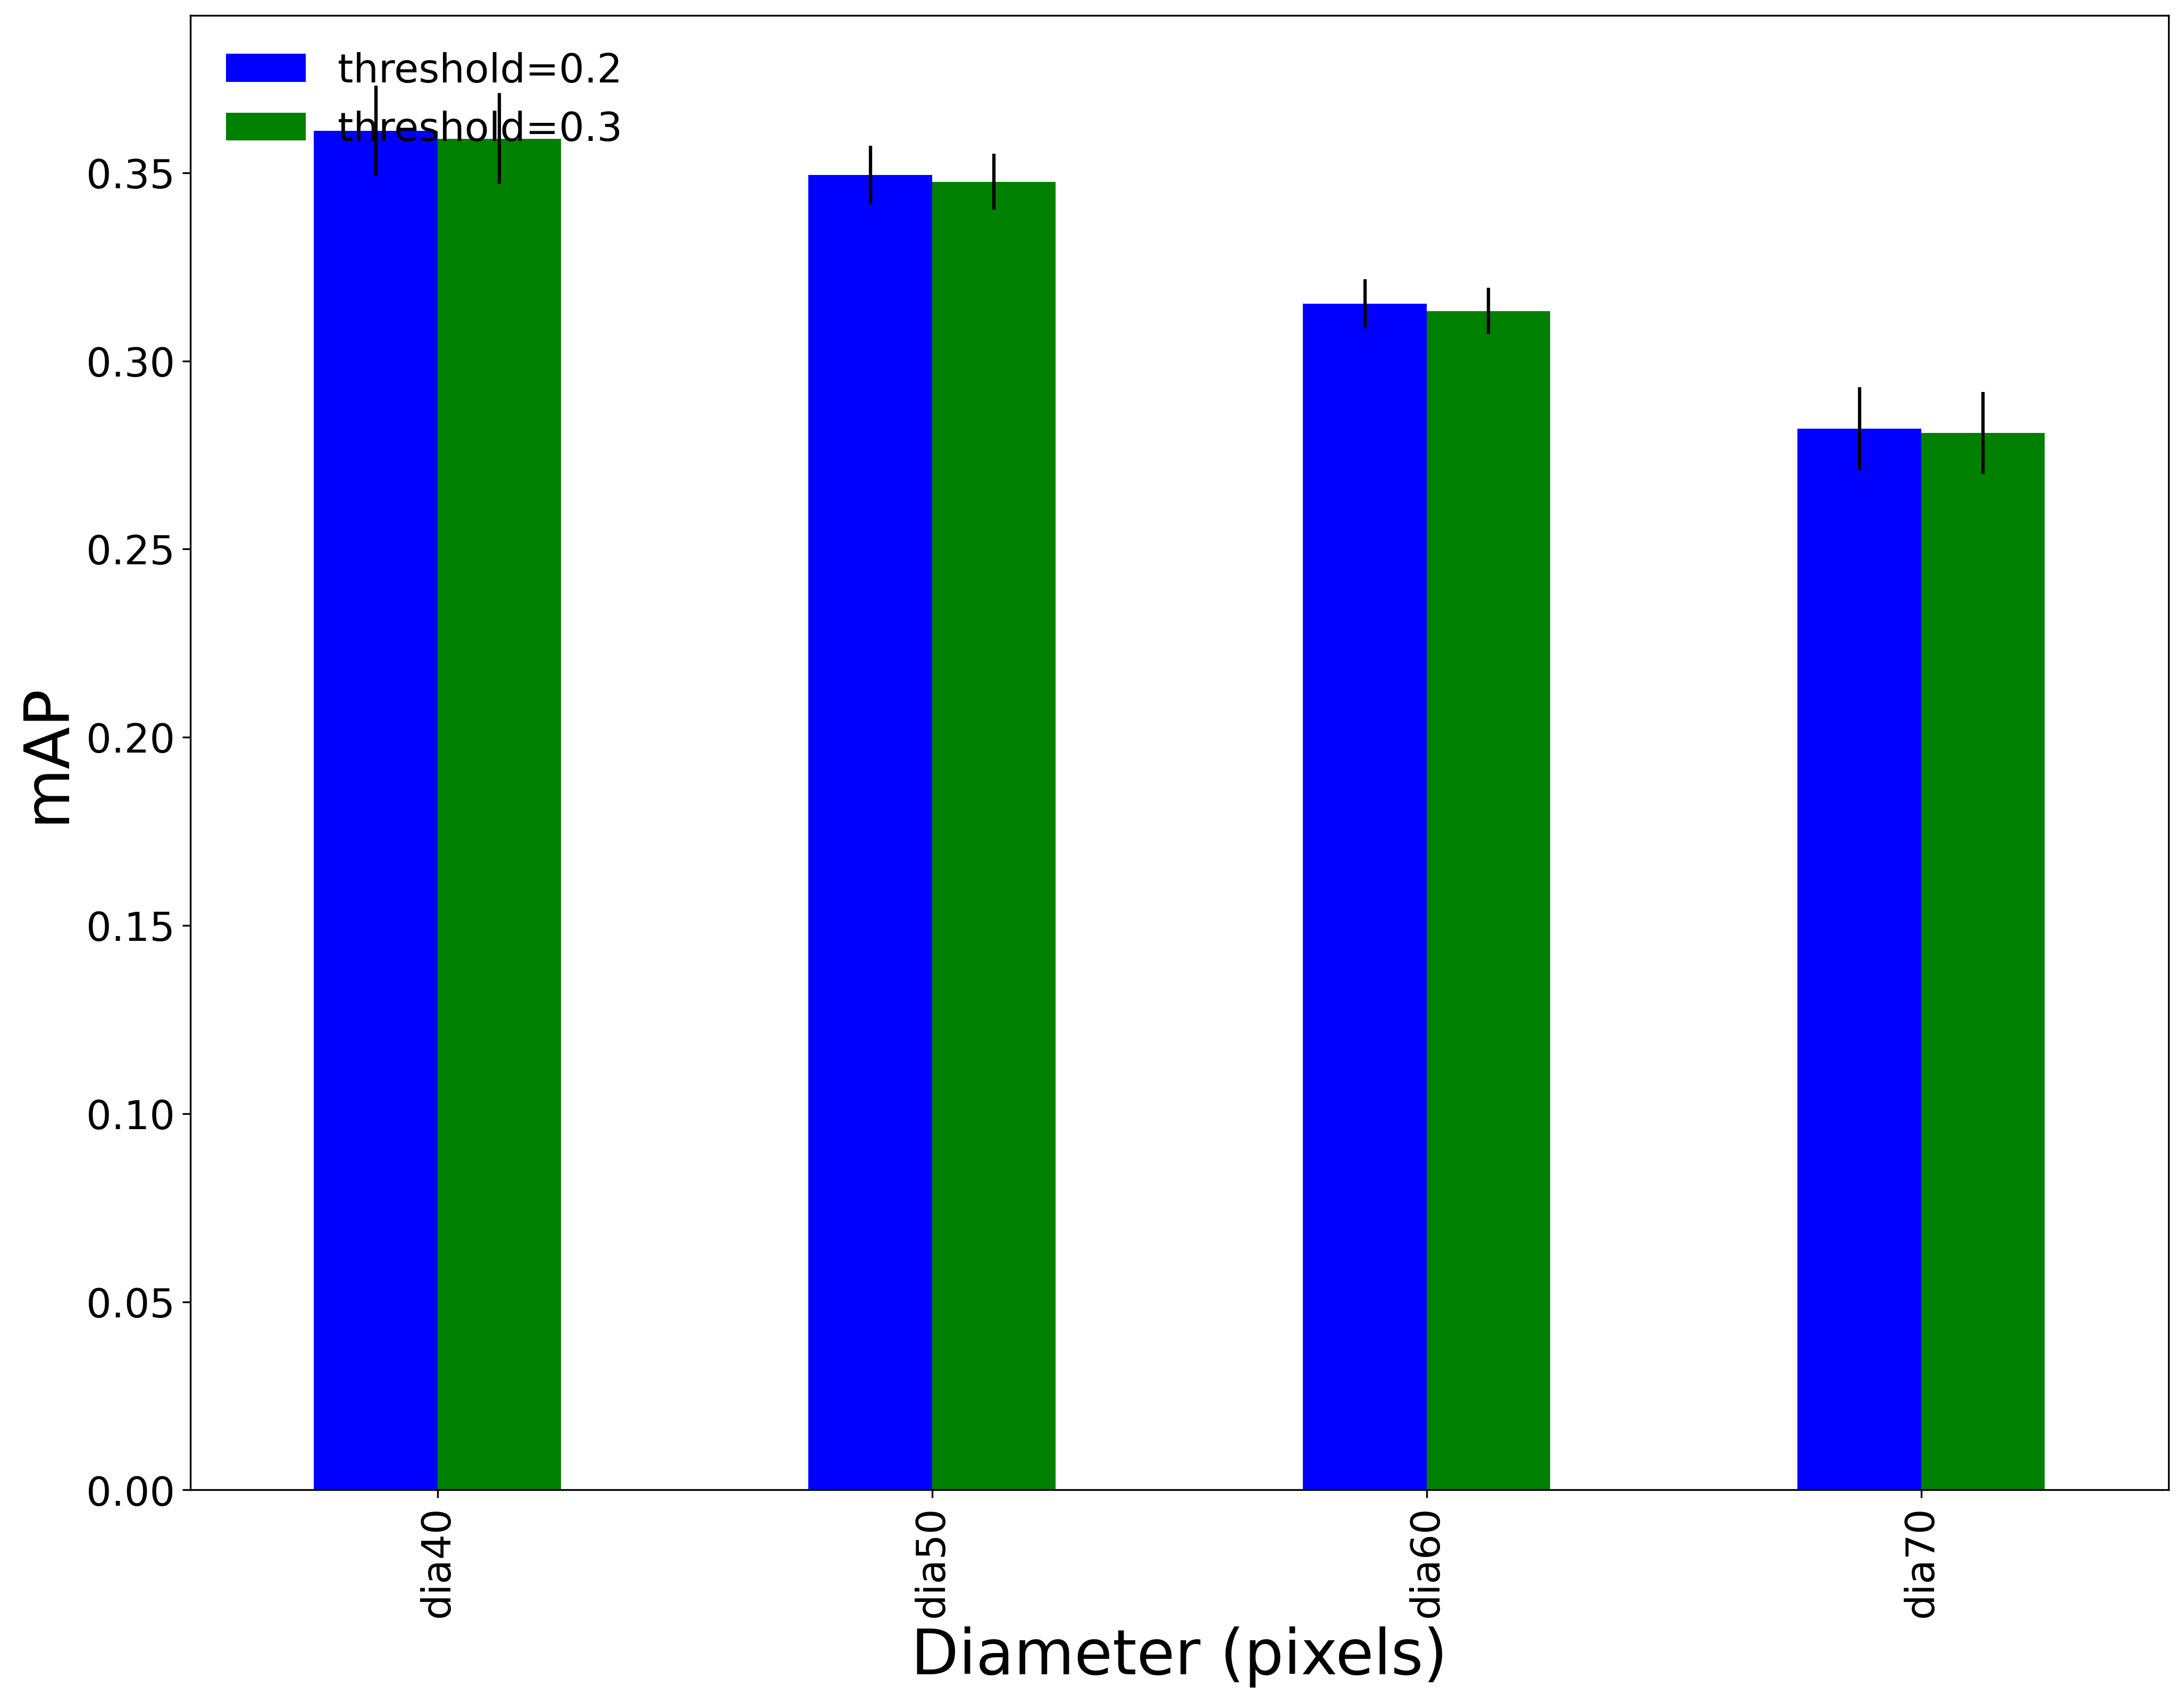

In [19]:
# res = stat1[stat1['dia']=='100']
# res.head()
# thre_list = [ 0.2,0.25, 0.5]
thre_list = [ 0.2,0.3]
dia_list = [40,50,60,70]
#dia_list = [25,50,75,100,125]

df = pd.DataFrame()

#the groups can vary 
grp1 = 'thre=0.20'
grp2 = 'thre=0.3'
# grp3 = 'thre=0.5'


# df['label'] = ['dia10','dia20','dia25']

df['label'] = ['dia40','dia50','dia60','dia70']
# a = stat_mean[stat_mean['thre']=='0.075']['precision']
# a.head()
df[grp1+'_mean'] = stat_mean[stat_mean['thre']==0.2]['precision'].values
df[grp2+'_mean'] = stat_mean[stat_mean['thre']==0.3]['precision'].values
# df[grp3+'_mean'] = stat_mean[stat_mean['thre']==0.5]['precision'].values


df[grp1+'_SE'] = stat_se[stat_se['thre']==0.2]['precision'].values
df[grp2+'_SE'] = stat_se[stat_se['thre']==0.3]['precision'].values
# df[grp3+'_SE'] = stat_se[stat_se['thre']==0.5]['precision'].values

list_legend= ['threshold='+str(thre) for thre in thre_list]
fig,ax = plt.subplots(1,1, figsize=(16,12))

df.plot.bar(x='label', 
                y=[grp1+'_mean',grp2+'_mean'],
                yerr=df[[grp1+'_SE',grp2+'_SE']].T.values, ax=ax,color=['b','g','r','c','m','y','k'])


ax.legend(list_legend,loc='upper left',frameon=False,fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylabel('mAP',fontsize =28)
ax.set_xlabel('Diameter (pixels)',fontsize =28)